#Important
This notebook has only reading permissions and you won't be able to edit it. You can make a copy of it by going to file -> save a copy in drive. Then, you will get an exact notebook that you'll be able to edit and work with.

To participate, send the notebook (and any other relevant material) and the submission csv (with the columns appointment_id, prediction ) to bernat.gordo@ailylabs.com before 23:59 of Sunday, May 1. Remember that the prediction columns must be the continious score given by the model, and not the predictions cut in 0s and 1s.

#0. About Aily
At AILY LABS we are on a mission to re-think the “way of working” and driving business performance. Our vision is to develop beautiful digital AI products that are easy to integrate. We believe in challenging the status quo and empowering business with meaningful AI.

https://www.linkedin.com/company/ailylabs

https://ailylabs.com/


If you'd like to join us, send your CV to bestjobs@ailylabs.com

aily_logo.svg


# 1. Introduction
##  1.1 The problem statement: no-shows in health appointments

A no-show occurs when a patient does not attend a doctor's appointment that he/she had scheduled. For every missed appointment, there is a need to reschedule the patient. In addition, the doctor misses an opportunity to see another patient who could have taken the original time slot and benefitted by being seen.

Missed appointments not only have an impact on patients' health, but they also have significant monetary costs. A study [1] found that missed appointments in the U.S. cost the industry an astounding \$150 billion dollars every year. On average, each physician loses \$200 per unused time slot.


Our most precious resource in health care is the scarcely available time and expertise of the people who care for patients. So it’s essential that we ensure that patients are seen when they need to be.



## 1.2 A Machine Learning approach for tackling patient no-show
The most common approach to curb no-shows is reaching out to the patients in advance. However, every contact has a cost that must be covered by the health system. Therefore, the contact strategy must be somehow optimized. 

In this context, leveraging machine learning methods can help us to define a personalized reachability action, by only targeting those patients that have a higher risk of being a no-show, thus significantly reducing the overall contact costs.


# 2 The challenge
## 2.1 The data
We have been given a doctor's appointment dataset. Each row is a specific appointment in the past and we have available the following features:
 *  **appointment_id**: Numerical identifier of each appointment
 *  **gender**: Gender of the patient
 *  **scheduled_day**: Date and hour when the appointment was scheduled
 *  **appointment_day**: Date and hour of the appointment
 *  **age**: age of the patient
 *  **neighborhood**: neighborhood of the patient 
 *  **has_insurance**: indicates whether the patient has health insurance or not (1 =Yes and 0 =No)
 *  **hypertension**: indicates whether the patient suffers from hypertension or not (1 =Yes and 0 =No)               
 *  **diabetes**: indicates whether the patient suffers from diabetes or not (1 =Yes and 0 =No)                      
 *  **alcoholism**: indicates whether the patient suffers from alcoholism or not (1 =Yes and 0 =No)    
 *  **non_specialized_visit**: indicates whether the visit is a general visit (0) or not some specialization (>0)
 *  **sms_received**: indicates whether the patient received an SMS as a reminder of the appointment  (1=Yes and 0=No)    
 *  **num_prior_appointments**: number of prior appointments the patient attended during the last year    
 *  **total_cost_public_health**:   estimated cost of the patient to the public health system in €
 *  **has_health_app**:  indicates whether the patient has the national health system app installed (0=No 1=Yes)

On top of that, we have a column (**no_show**) that indicates whether a no-sow occurred (0 if the patient showed up and 1 if not). Our goal is to predict this variable using the appointment's features. 


## 2.2 Building a model that predicts no-show
Using the data described above, our main goal is to build a machine learning model able to predict those medical appointments that have a high risk of not-show. 

The winner of the challenge will be the team that achieves the better model in terms of predictive performance: that is to say, the model that predicts the best no-show appointments.

The data has been split into two datasets:


*   **Train dataset:** this dataset contains data for 83k appointments and all the variables, including the target variable no_show. It will be used to train our machine learning solution.
*   **Test dataset:** this dataset contains data for 28k appointments and  all the variables, except the target variable (although we do know it, we kept it for ourselves). You will have to use your machine learning model (built using the train data) to predict the likelihood of a show over the test set. 

We will then compare your predictions over the test set with the real values. The team that scores the highest match between predictions and real values will be the winner. The performance metric that we will use to compare predictions with targets is the Area Under the ROC curve (aka AUC) (https://en.wikipedia.org/wiki/Receiver_operating_characteristic).


To make things easier, in this notebook you'll find a proposal for the problem resolution, so you have something to begin with. But, we dare you to improve our solution!

We used Python to approach this challenge, but if you feel more comfortable with R, feel free to use it.

# 3. Solution

We have prepared a proposal of a solution of the problem. However, this is nor the only one nor the best one, thus, we encourage you to try it by yourself and improve our result!

## 3.1 Enviorment Setup & Data Loading

Let's import the required libraries and load the data

In [1]:
# Data handling
import pandas as pd
import numpy as np
import datetime
import missingno as msno
from tabulate import tabulate
# Counter
from collections import Counter

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing & Machine learning
import sklearn
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer, KNNImputer

from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, roc_curve
# Modelling
import xgboost as xgb
from xgboost import plot_importance

# Shapely values
!pip install shap
import shap


## 3.2 Exploratory Data Analysis (EDA)

Exploratory Data Analysis refers to the critical process of performing initial investigations on data so as to discover patterns,to spot anomalies,to test hypothesis and to check assumptions with the help of summary statistics and graphical representations.

Our target is the variable *no_show*, hence, we will focus our efforts on this variable and it's relation to the rest of variables.

In [2]:
# Let's read the data
df_train = pd.read_csv('train.csv')
# Let's do some basic exploration
s = df_train.shape
print(f"Training data has {s[0]} rows and {s[1]} columns.")
df_train.head()

Training data has 82895 rows and 16 columns.


,appointment_id,gender,scheduled_day,appointment_day,age,neighbourhood,has_insurance,hipertension,diabetes,alcoholism,non_specialized_visit,sms_received,no_show,num_prior_appointments,total_cost_public_health,has_health_app
0,5767698,F,2016-06-03T06:44:55Z,2016-06-08T00:00:00Z,49.0,OTHER,0.0,1.0,0.0,0.0,0.0,0.0,0,3.0,13380.729360,1.0
1,5663873,F,2016-05-05T10:41:35Z,2016-05-18T00:00:00Z,45.0,OTHER,1.0,0.0,0.0,0.0,0.0,0.0,1,2.0,12862.064714,0.0
2,5663052,M,2016-05-05T09:25:43Z,2016-05-20T00:00:00Z,36.0,OTHER,0.0,0.0,0.0,0.0,0.0,0.0,0,6.0,20813.096845,1.0
3,5671513,F,2016-05-06T17:39:08Z,2016-05-10T00:00:00Z,51.0,OTHER,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,NaN,0.0
4,5693146,F,2016-05-12T17:57:58Z,2016-05-16T00:00:00Z,53.0,JESUS DE NAZARETH,1.0,1.0,0.0,0.0,0.0,1.0,0,2.0,11031.959590,0.0


## Basic Data Analysis
A general summary of all the variables will give us an idea of their distribution.

In [3]:
df_train.describe()

,appointment_id,age,has_insurance,hipertension,diabetes,alcoholism,non_specialized_visit,sms_received,no_show,num_prior_appointments,total_cost_public_health,has_health_app
count,8.289500e+04,76922.000000,76623.000000,76874.000000,75533.000000,76883.000000,75986.000000,77745.000000,82895.000000,76609.000000,77738.000000,78662.000000
mean,5.675099e+06,37.139713,0.097986,0.197245,0.072909,0.030111,0.022215,0.319686,0.202859,2.217155,11973.117387,0.266240
std,7.136604e+04,23.131048,0.297298,0.397921,0.259988,0.170893,0.161608,0.466358,0.402131,1.530059,3368.191290,0.441994
min,5.030230e+06,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.640120e+06,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,9706.814238,0.000000
50%,5.680401e+06,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,11965.005869,0.000000
75%,5.725336e+06,56.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,3.000000,14248.922925,1.000000
max,5.790484e+06,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000,1.000000,11.000000,26247.363173,1.000000


### 3.1.1 Univariate Analysis
When exploring the data, it's interesting to see the distribution of the variables we are studying. Here we see the distribution of the categorical variables.

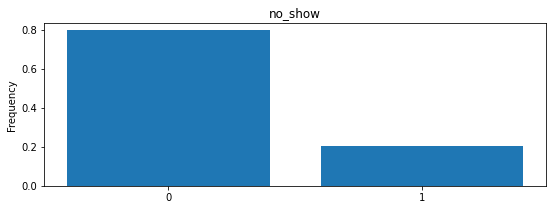

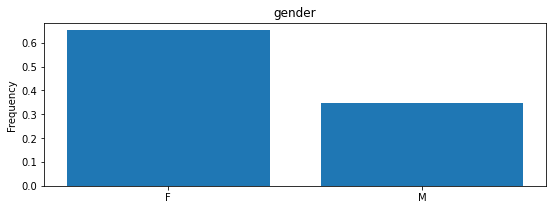

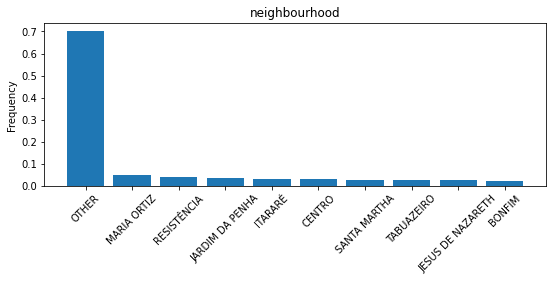

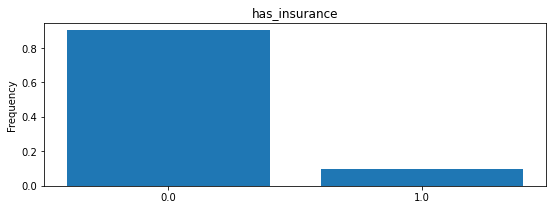

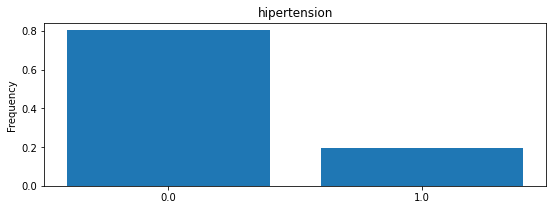

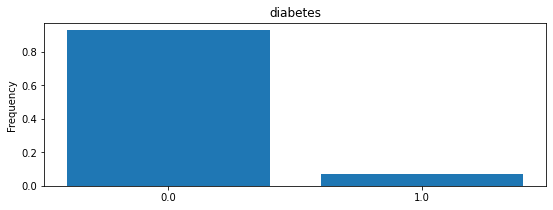

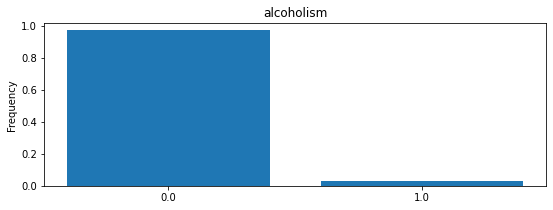

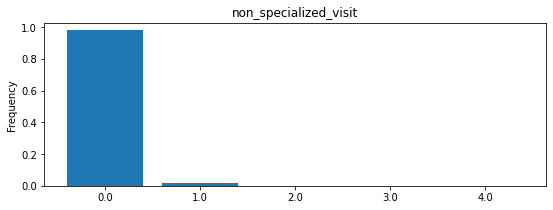

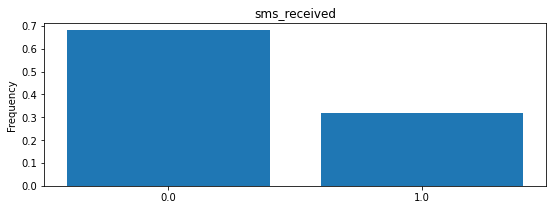

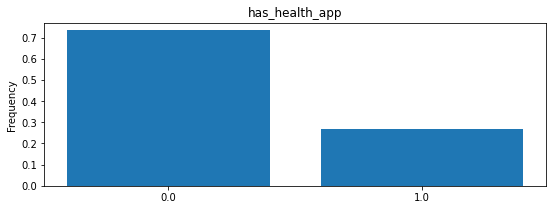

In [4]:
def bar_plot(variable, data):
  var = data[variable]
  varValue = var.value_counts(normalize=True)

  # visualize
  plt.figure(figsize = (9,3))
  plt.bar(varValue.index, varValue)
  if variable == 'neighbourhood':
    plt.xticks(varValue.index, varValue.index.values, rotation=45)
  else:
    plt.xticks(varValue.index, varValue.index.values)
  plt.ylabel("Frequency")
  plt.title(variable)
  plt.show()

category1 = ['no_show', 'gender','neighbourhood', 'has_insurance',
             'hipertension', 'diabetes','alcoholism', 'non_specialized_visit', 'sms_received', 'has_health_app']
for c in category1:
    bar_plot(variable=c, data=df_train)

Distribution of numerical variables should be also observed, in this case using histograms.

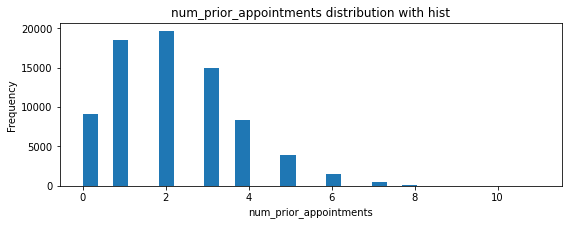

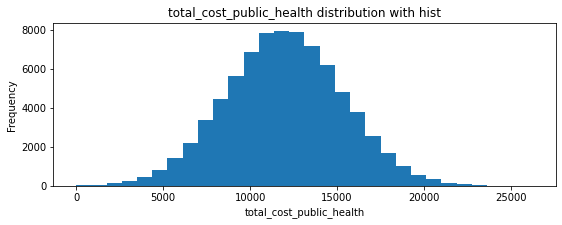

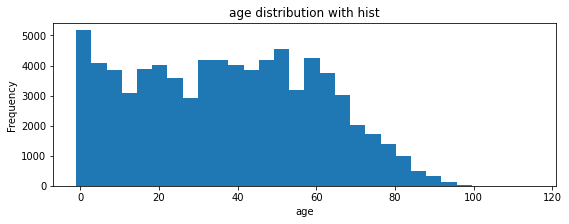

In [5]:
def plot_hist(variable):
  plt.figure(figsize = (9,3))
  plt.hist(df_train[variable], bins = 30)
  plt.xlabel(variable)
  plt.ylabel("Frequency")
  plt.title("{} distribution with hist".format(variable))
  plt.show()
  
numericVar = ["num_prior_appointments", "total_cost_public_health", "age"]
for n in numericVar:
    plot_hist(n)

### 3.1.2 Bivariate Analysis
Correlations between the variables are interesting to observe during EDA, as it can provide a first view of which variables could be important for explaining our response variable (no_show).

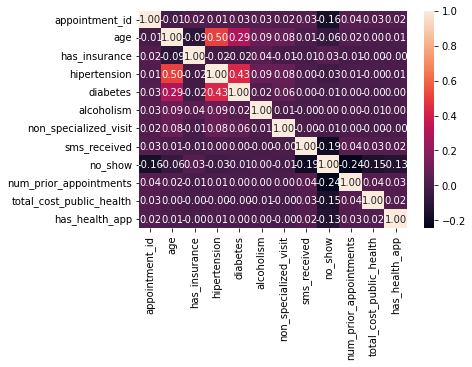

In [6]:
variables = ['appointment_id', 'gender', 'scheduled_day', 'appointment_day', 'age',
       'neighbourhood', 'has_insurance', 'hipertension', 'diabetes',
       'alcoholism', 'non_specialized_visit', 'sms_received', 'no_show',
       'num_prior_appointments', 'total_cost_public_health', 'has_health_app']
sns.heatmap(df_train[variables].corr(), annot = True, fmt = ".2f")
plt.show()

It seems like the variable no_show is negatively correlated with the number of prior appointments and the total cost in public health. Other notorious correlations could be between hipertension or diabetes, and age, which is expected, or the total cost in public health with the number of previous appointments, which is also understandable. Another interesting one could having received a sms or having the health app downloaded.


Given that we are interested in studying these variables in relation with no_show, it could be interesting to compare how this variable is distributed in each level of the categorical variables. This could give us a hint of important variables.

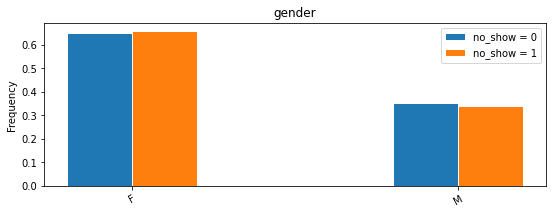

no_show         0         1
gender                     
F        0.648594  0.660195
M        0.351406  0.339805


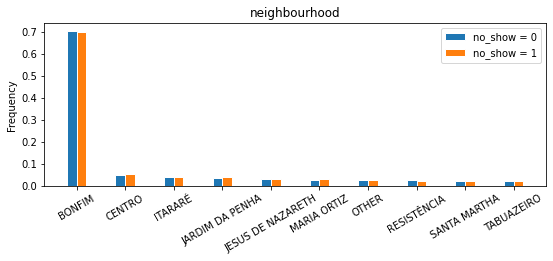

no_show                   0         1
neighbourhood                        
BONFIM             0.025518  0.024493
CENTRO             0.030516  0.030443
ITARARÉ            0.029330  0.039840
JARDIM DA PENHA    0.036827  0.029191
JESUS DE NAZARETH  0.024156  0.031947
MARIA ORTIZ        0.051580  0.055876
OTHER              0.703510  0.699386
RESISTÊNCIA        0.039839  0.041468
SANTA MARTHA       0.029731  0.022551
TABUAZEIRO         0.028994  0.024806


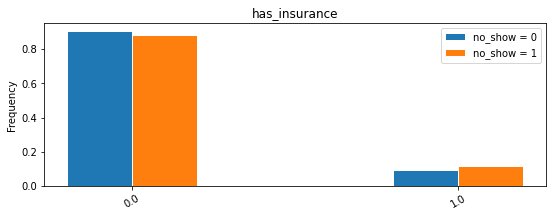

no_show               0         1
has_insurance                    
0.0            0.906861  0.882914
1.0            0.093139  0.117086


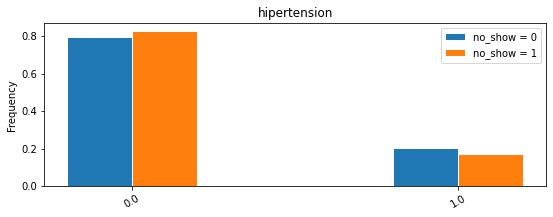

no_show              0         1
hipertension                    
0.0           0.796327  0.828067
1.0           0.203673  0.171933


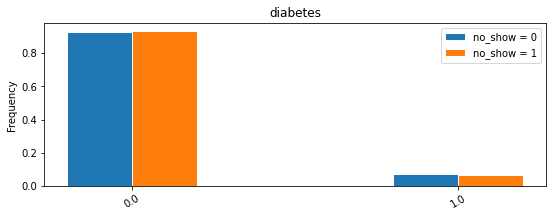

no_show         0         1
diabetes                   
0.0       0.92518  0.934579
1.0       0.07482  0.065421


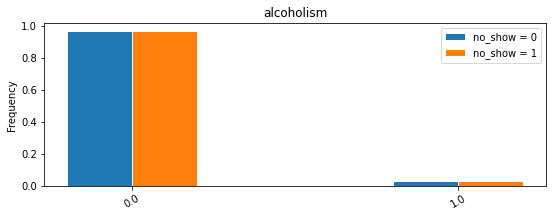

no_show            0         1
alcoholism                    
0.0         0.970164  0.968808
1.0         0.029836  0.031192


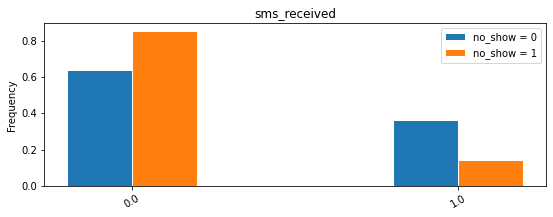

no_show              0         1
sms_received                    
0.0           0.636239  0.853332
1.0           0.363761  0.146668


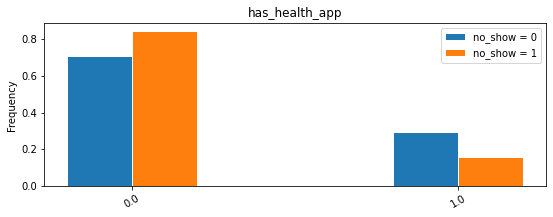

no_show                0         1
has_health_app                    
0.0             0.705757  0.843404
1.0             0.294243  0.156596


In [7]:
def bar_plot(variable, data, respvar):
  """
  Distribution of the variables depending on the value of a binomial variable
  """
  var = data[[variable, respvar]]

  var0 = var.loc[var[respvar] == 0].value_counts(normalize=True)
  var1 = var.loc[var[respvar] == 1].value_counts(normalize=True)

  # visualize
  plt.figure(figsize = (9,3))
  barWidth = 0.20
  r1 = np.arange(len(var0))
  r2 = [x + barWidth for x in r1]
  plt.bar(r1, var0, width=barWidth, edgecolor='white', label="{} = 0".format(respvar))
  plt.bar(r2, var1, width=barWidth, edgecolor='white', label="{} = 1".format(respvar))
  plt.xticks([r + 0.10 for r in range(len(var0))], np.unique(list(df_train[variable])), rotation=30)
  plt.legend()
  plt.ylabel("Frequency")
  plt.title(variable)
  plt.show()
  print(pd.crosstab(data[variable], data.no_show, normalize='columns'))


category1 = ['gender','neighbourhood', 'has_insurance', 'hipertension', 'diabetes','alcoholism', 'sms_received', 'has_health_app']
respvar = "no_show"
for c in category1:
    bar_plot(variable=c, data=df_train, respvar=respvar)

For numeric variables we generate 4 different buckets to categorize and see how is the no show distribution in the different buckets.

In [8]:
#total_cost_public_health - no_show
total_cost_public_health= df_train[['total_cost_public_health','no_show']]
total_cost_public_health['total_cost_public_health'] = pd.qcut(total_cost_public_health['total_cost_public_health'], q=4)

total_cost_public_health[["total_cost_public_health","no_show"]].groupby(["total_cost_public_health"], as_index = False).mean().sort_values(by="no_show",ascending = False)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,total_cost_public_health,no_show
0,"(-0.001, 9706.814]",0.285053
1,"(9706.814, 11965.006]",0.217145
2,"(11965.006, 14248.923]",0.177524
3,"(14248.923, 26247.363]",0.132081


Here we can see that people who accumulates a bigger cost in the public health care is more likely to show up at the doctor appointment.

In [9]:
#age - no_show
age = df_train[['age','no_show']]
age['age'] = pd.qcut(age['age'], q=4)

age[["age","no_show"]].groupby(["age"], as_index = False).mean().sort_values(by="age",ascending = True)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,age,no_show
0,"(-1.001, 18.0]",0.221437
1,"(18.0, 37.0]",0.235039
2,"(37.0, 56.0]",0.193760
3,"(56.0, 115.0]",0.157105


Younger people are more likley not to show up at the appointment.

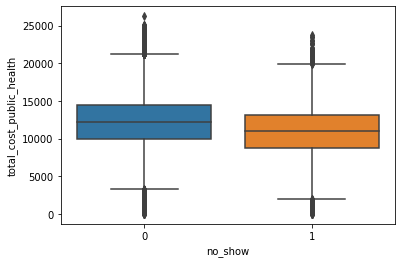

In [10]:
sns.boxplot(x="no_show", y="total_cost_public_health", data=df_train)

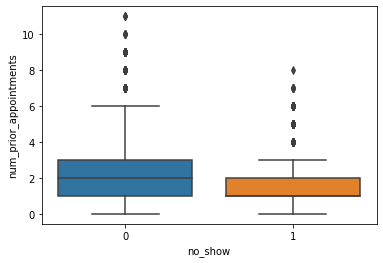

In [11]:
sns.boxplot(x="no_show", y="num_prior_appointments", data=df_train)

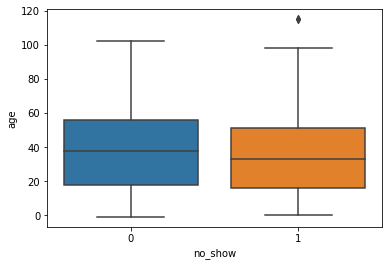

In [12]:
sns.boxplot(x="no_show", y="age", data=df_train)

**Conclusions from the EDA:**
- No_show variable is negatively correlated with the number of prior appointments and the total cost spent in public health.

- Having downloaded the app and having received the sms are also correlated with no_show.

- It could be that younger people are more likely not to show up.

- No_show seems similarly distributed among the other variables.


## Outlier detection
Machine learning algorithms are sensitive to the range and distribution of attribute values. Outliers are points in our data that have a different underlying behavior than the rest of the data.

To have more accurate models we should always identify if we have outliers in our data.

There are different ways of detecting outliers, in this case we will consider outliers those observations that are above or below 1.5 times the interquartile range of the numeric variable.

In [13]:
def detect_outliers(df,features):
  """
  This function returns possible outliers according to the IQR
  """
  outlier_indices = []
  for c in features:
        # 1st quartile
        Q1 = np.percentile(df[c],25)
        # 3rd quartile
        Q3 = np.percentile(df[c],75)
        # IQR
        IQR = Q3 - Q1
        # Outlier step
        outlier_step = IQR * 1.5
        # detect outlier and their indeces
        outlier_list_col = df[(df[c] < Q1 - outlier_step) | (df[c] > Q3 + outlier_step)].index
        # store indeces
        outlier_indices.extend(outlier_list_col)
        
        outlier_indices = Counter(outlier_indices)
        multiple_outliers = list(i for i, v in outlier_indices.items() if v > 2)
        return multiple_outliers

We see how many outliers our function found for our numeric variabes. 

In [14]:
df_train.loc[detect_outliers(df_train,["age", "total_cost_public_health", "num_prior_appointments"])]

,appointment_id,gender,scheduled_day,appointment_day,age,neighbourhood,has_insurance,hipertension,diabetes,alcoholism,non_specialized_visit,sms_received,no_show,num_prior_appointments,total_cost_public_health,has_health_app


We see that according to this outlier criteria we don't have outliers.

## 3.3 Feature Engineering
Feature engineering is a machine learning technique that leverages data to create new variables that aren’t in the training set. It can produce new with the goal of simplifying and speeding up data transformations while also enhancing model accuracy. Feature engineering is required when working with machine learning models.

Feature Egineering from dates
Even though dates can not be directly processed and understood by most algorithms, this that not mean that they do not contain powerful information. In our problem we have two dates: the date when the appointment was scheduled and the date when the appointment took place. Let's see what new features we can extract from these two dates.

Let's have a look at these features:

In [15]:
df_train[['scheduled_day', 'appointment_day']].head()

,scheduled_day,appointment_day
0,2016-06-03T06:44:55Z,2016-06-08T00:00:00Z
1,2016-05-05T10:41:35Z,2016-05-18T00:00:00Z
2,2016-05-05T09:25:43Z,2016-05-20T00:00:00Z
3,2016-05-06T17:39:08Z,2016-05-10T00:00:00Z
4,2016-05-12T17:57:58Z,2016-05-16T00:00:00Z


The dates are in fact a timestamp that contains both date and hour. Let's split each of them into date and hour.

In [16]:
df_train['scheduled_day'] = df_train['scheduled_day'].astype('str')
df_train['appointment_day'] = df_train['appointment_day'].astype('str')
# Define a lambda functions that will extract substrings from the dates
extract_date = lambda x: x[:10]
extract_hour = lambda x: x[11:19]

# Extract dates
df_train['scheduled_date'] = df_train['scheduled_day'].apply(extract_date)
df_train['appointment_date'] = df_train['appointment_day'].apply(extract_date)

# Extract hours
df_train['scheduled_hour'] = df_train['scheduled_day'].apply(extract_hour)
df_train['appointment_hour'] = df_train['appointment_day'].apply(extract_hour)

Now we have date and hours separatedly. What new features can we come up with?

For example, we can compute the days between the schedule date and the appointment date. We could hypotesize that those appointments with larger number of dates between scheduling and appointment could be more prone to a no-show, as the patient is more likely to forget about the appointment.

In [17]:
# to operate between dates we first need to convert them to a date format
# to do so, we'll use datetime library
day1 = '2021-05-07'
df_train['scheduled_date_2'] = pd.to_datetime(df_train['scheduled_date'], 
                                              format='%Y-%m-%d')
df_train['appointment_date_2'] = pd.to_datetime(df_train['appointment_date'], 
                                              format='%Y-%m-%d')

# Now we can compute the difference between dates
df_train['num_dayes_between_sch_and_ap'] = (df_train['appointment_date_2'] - 
                                            df_train['scheduled_date_2']).dt.days
df_train[['scheduled_date_2','appointment_date_2','num_dayes_between_sch_and_ap']].head()

# We can drop now the appointment and schedule dates
to_drop = ['scheduled_date', 'appointment_date', 'scheduled_date_2',
           'appointment_date_2','scheduled_day','appointment_day']
df_train = df_train.drop(to_drop, axis=1)


Next, let's se what can we do with the hours.

In [18]:
# for some reason appointment hours are constant at 0am, thus they are usless
print(df_train['appointment_hour'].unique())
df_train = df_train.drop('appointment_hour', axis=1)

['00:00:00' '']


We do have, however, information for the scheduling hours. We will extract the hour and, we will define a categorical feature that will indicate when the appointment was shceduled (morning, afternoon or night).

In [19]:
df_train['scheduled_just_hour'] = df_train['scheduled_hour'].apply(lambda x: pd.to_numeric(x[:2]) )

# Now categorize the hours into morning, afternoon and night
# Start with night and then relevel those values with either morning or afternoon
df_train['scheduled_moment_cat'] = 'night'
df_train.loc[(df_train['scheduled_just_hour'] > 6)  &
             (df_train['scheduled_just_hour'] <= 14),
             'scheduled_moment_cat'] = 'morning'

df_train.loc[(df_train['scheduled_just_hour'] > 14)  &
             (df_train['scheduled_just_hour'] <= 21),
             'scheduled_moment_cat'] = 'afternoon'
             

# Let's drop the hours columns, but we'll keep the "scheduled_just_hour", who knows
# it might be useful after all

if 'scheduled_hour' in df_train.columns:
  df_train = df_train.drop('scheduled_hour', axis=1)
if 'appointment_hour' in df_train.columns:
  df_train = df_train.drop('appointment_hour', axis=1)


### Other features with business-like sense

Sometimes, we can combine variables to yield new variables with that can have sense from the use case prespective. For example, in our data we have available the cost of the patient for the health system, as well as the number of prior appointments. Thus, we can compute the ratio between these two to obtain the avreage cost per visit for each patient.

In [20]:
df_train['cost_per_visit'] = df_train['total_cost_public_health']/df_train['num_prior_appointments']

# Fill infinite values with 0's
df_train = df_train.replace([np.inf, -np.inf], 0)

## 3.2 Preprocessing

A real-world data generally contains noises, missing values, and maybe in an unusable format which cannot be directly used for machine learning models. Data preprocessing is required tasks for cleaning the data and making it suitable for a machine learning model.


### 3.2.1 Missing data handling
Missing data is a typical problem that must be dealed with when doing data anaylsis. First, we can visualize how the missing data is distributed among the variables.

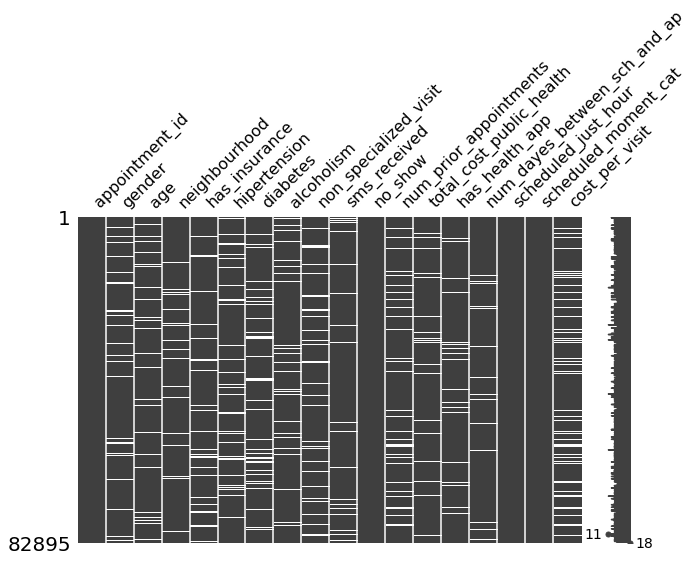

In [21]:
msno.matrix(df_train, figsize=(10, 6))

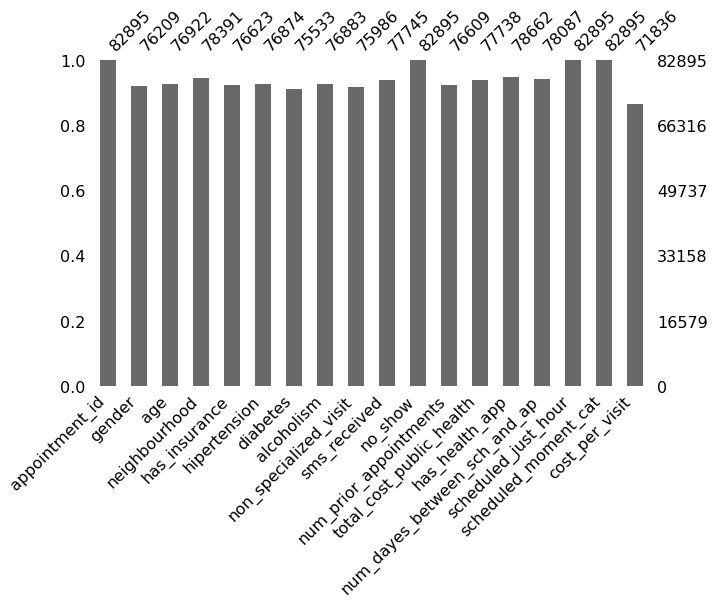

In [22]:
msno.bar(df_train, figsize=(10, 6))

**Imputation of the missing values**
Missing values could be removed, but this would mean losing a big amount of information. Another soultion is the imputation of these values, which incorporates the information that is already in the data to complete the missings.

In [23]:
df_train.isnull().sum()/len(df_train)

appointment_id                  0.000000
gender                          0.080656
age                             0.072055
neighbourhood                   0.054334
has_insurance                   0.075662
hipertension                    0.072634
diabetes                        0.088811
alcoholism                      0.072525
non_specialized_visit           0.083346
sms_received                    0.062127
no_show                         0.000000
num_prior_appointments          0.075831
total_cost_public_health        0.062211
has_health_app                  0.051065
num_dayes_between_sch_and_ap    0.058001
scheduled_just_hour             0.000000
scheduled_moment_cat            0.000000
cost_per_visit                  0.133410
dtype: float64

#### Simple Imputer

In [24]:
# #SimpleImputer for numeric variables, we use median imputation
# numeric_cols = df_train.select_dtypes(include=np.number).columns.tolist()
# categorical_cols = df_train.select_dtypes('object').columns.tolist()
# # we remove the target
# numeric_cols.remove("no_show")

# imputer = SimpleImputer(strategy ='median')
# imputer.fit(df_train[numeric_cols])
# df_train[numeric_cols] = imputer.transform(df_train[numeric_cols])

# #For categorical we use most frequent value (mode)
# df_train = df_train.fillna(df_train.mode().iloc[0])

#### KNN Imputer

In [25]:
#KNNImputer for numeric variables, we use median imputation
numeric_cols = df_train.select_dtypes(include=np.number).columns.tolist()
categorical_cols = df_train.select_dtypes('object').columns.tolist()
# we remove the target
numeric_cols.remove("no_show")

imputer = KNNImputer(n_neighbors=5)
df_train[numeric_cols] = imputer.fit_transform(df_train[numeric_cols])

#For categorical we use most frequent value (mode)
df_train = df_train.fillna(df_train.mode().iloc[0])

In [26]:
df_train.isnull().sum()

appointment_id                  0
gender                          0
age                             0
neighbourhood                   0
has_insurance                   0
hipertension                    0
diabetes                        0
alcoholism                      0
non_specialized_visit           0
sms_received                    0
no_show                         0
num_prior_appointments          0
total_cost_public_health        0
has_health_app                  0
num_dayes_between_sch_and_ap    0
scheduled_just_hour             0
scheduled_moment_cat            0
cost_per_visit                  0
dtype: int64

### 3.3.3 Standarizing numerical features
Standarization is scaling technique where the values are centered around the mean with a unit standard deviation The goal os scaling is having all numeric features in a similar scale. This can help the gradient descent, and other optimization algorithms to converge more quickly towards the minima.


To to the standarization, we will use the scikit-learn library

In [27]:
ss = sklearn.preprocessing.StandardScaler()

# Split data intro numerical features and categorical features
num_features = ['num_dayes_between_sch_and_ap','cost_per_visit', 'total_cost_public_health',
                'scheduled_just_hour','age']

df_num = df_train[num_features]
df_num_scaled = ss.fit_transform(df_num)

# Convert it back to a pandas Data Frame
df_num_scaled = pd.DataFrame(df_num_scaled, columns=df_num.columns)

# Concatenate numeric with categorical into a whole dataset again

# extract cat columns
cat_features = [col for col in df_train.columns if col not in num_features]
df_cat = df_train[cat_features]

# Concatenate categorical and numerical back together
df_train = pd.concat([df_cat, df_num_scaled], axis=1)
df_train.head()

,appointment_id,gender,neighbourhood,has_insurance,hipertension,diabetes,alcoholism,non_specialized_visit,sms_received,no_show,num_prior_appointments,has_health_app,scheduled_moment_cat,num_dayes_between_sch_and_ap,cost_per_visit,total_cost_public_health,scheduled_just_hour,age
0,5767698.0,F,OTHER,0.0,1.0,0.0,0.0,0.0,0.0,0,3.0,1.0,night,-0.343335,-0.297367,0.428560,-1.484732,0.526924
1,5663873.0,F,OTHER,1.0,0.0,0.0,0.0,0.0,0.0,1,2.0,0.0,morning,0.184740,0.177462,0.270596,-0.241063,0.348972
2,5663052.0,M,OTHER,0.0,0.0,0.0,0.0,0.0,0.0,0,6.0,1.0,morning,0.316759,-0.536227,2.692152,-0.551981,-0.051422
3,5671513.0,F,OTHER,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,afternoon,-0.409344,-0.142625,0.284670,1.935356,0.615901
4,5693146.0,F,JESUS DE NAZARETH,1.0,1.0,0.0,0.0,0.0,1.0,0,2.0,0.0,afternoon,-0.409344,-0.043004,-0.286778,1.935356,0.704877



### 3.2.4 Encoding of Categorical Features
Since most machine learning models only accept numerical variables, preprocessing the categorical variables becomes a necessary step. We need to convert these categorical variables to numbers such that the model is able to understand and extract valuable information.

There are several approaches to tackle this task. We will discuss three of them on the variable `neighbourhood`. 

Label encoding or ordinal encoding

The easiest way to do this is to assign a number (or label) to each of these categories.

For example, if we had a variable height, which can take values tall, medium and short, then we could encode each of these categories as 3, 2, 1, respectively; because there is an intrinsic order.

* **One-hot encoding**

    A trivial approach for nominal variables (as our case) is to split the categorical variables into many binary variables (those that can only take 0 or 1).
    
    For example, we could have a nominal variable `color` that takes values `red`, `yellow` or `green`. Then we can split the original variable `color` into two new ones: `is_red` and `is_yellow`. Note that it is unncessary to create `is_green` because its value can be infereced from the previous pair of variables.
    
    This means that we will have to add nearly as much variables as the number of categories. This is sometimes a problem, but we will ignore it for now.

    The code below shows how to split the variable `neighbourhood`.

    * **Mean encoding**

    This is the encoding that takes into account the target variable (in our case, `not_show`). It labels each category of the variable as the mean of the target conditioned to the category. In our case, it estimates the probability of observing `no_show`=1 conditioned to the categorical variable's value:
$$\text{Pr}(\text{no show}| \text{neighbourhood = category}) = \frac{\text{Pr}(\text{no show and neighbourhood = category})}{\text{Pr}(\text{neighbourhood = category})}$$

    Sometimes, learning with mean encoding may lead to **overfitting** (the model is "memorizing" the training dataset but not generalizing). In that case, we have to apply regularisation techniques that will not be discussed here.


Now that we have seen some basic encodings, we will proceed to encode all the categorical variables that we have in our dataset.

Specifically, we will use one hot encoding
You can try other encodings for each variable.

#### OneHot Encoding

In [28]:
# df_train.head()
# to_onehot = ['gender','neighbourhood','scheduled_moment_cat']
# df_to_onehot = df_train[to_onehot]
# df_encoded = pd.get_dummies(df_to_onehot, drop_first = True)

# # Drop non encodded variabes from dataset
# df_train = df_train.drop(to_onehot, axis=1)

# # Add the encoded dataset to the train dataset
# df_train = pd.concat([df_train, df_encoded], axis=1)
# df_train.head()

Mean Encoding

In [29]:
df_train.head()

,appointment_id,gender,neighbourhood,has_insurance,hipertension,diabetes,alcoholism,non_specialized_visit,sms_received,no_show,num_prior_appointments,has_health_app,scheduled_moment_cat,num_dayes_between_sch_and_ap,cost_per_visit,total_cost_public_health,scheduled_just_hour,age
0,5767698.0,F,OTHER,0.0,1.0,0.0,0.0,0.0,0.0,0,3.0,1.0,night,-0.343335,-0.297367,0.428560,-1.484732,0.526924
1,5663873.0,F,OTHER,1.0,0.0,0.0,0.0,0.0,0.0,1,2.0,0.0,morning,0.184740,0.177462,0.270596,-0.241063,0.348972
2,5663052.0,M,OTHER,0.0,0.0,0.0,0.0,0.0,0.0,0,6.0,1.0,morning,0.316759,-0.536227,2.692152,-0.551981,-0.051422
3,5671513.0,F,OTHER,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,afternoon,-0.409344,-0.142625,0.284670,1.935356,0.615901
4,5693146.0,F,JESUS DE NAZARETH,1.0,1.0,0.0,0.0,0.0,1.0,0,2.0,0.0,afternoon,-0.409344,-0.043004,-0.286778,1.935356,0.704877


In [30]:
mean_encode = df_train.groupby('scheduled_moment_cat')['no_show'].mean()

df_train.loc[:, 'scheduled_moment_cat'] = df_train.loc[:, 'scheduled_moment_cat'].map(mean_encode)
df_train.head()

,appointment_id,gender,neighbourhood,has_insurance,hipertension,diabetes,alcoholism,non_specialized_visit,sms_received,no_show,num_prior_appointments,has_health_app,scheduled_moment_cat,num_dayes_between_sch_and_ap,cost_per_visit,total_cost_public_health,scheduled_just_hour,age
0,5767698.0,F,OTHER,0.0,1.0,0.0,0.0,0.0,0.0,0,3.0,1.0,0.193522,-0.343335,-0.297367,0.428560,-1.484732,0.526924
1,5663873.0,F,OTHER,1.0,0.0,0.0,0.0,0.0,0.0,1,2.0,0.0,0.196590,0.184740,0.177462,0.270596,-0.241063,0.348972
2,5663052.0,M,OTHER,0.0,0.0,0.0,0.0,0.0,0.0,0,6.0,1.0,0.196590,0.316759,-0.536227,2.692152,-0.551981,-0.051422
3,5671513.0,F,OTHER,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.234269,-0.409344,-0.142625,0.284670,1.935356,0.615901
4,5693146.0,F,JESUS DE NAZARETH,1.0,1.0,0.0,0.0,0.0,1.0,0,2.0,0.0,0.234269,-0.409344,-0.043004,-0.286778,1.935356,0.704877


In [31]:
mean_encode = df_train.groupby('neighbourhood')['no_show'].mean()

df_train.loc[:, 'neighbourhood'] = df_train.loc[:, 'neighbourhood'].map(mean_encode)
df_train.head()

,appointment_id,gender,neighbourhood,has_insurance,hipertension,diabetes,alcoholism,non_specialized_visit,sms_received,no_show,num_prior_appointments,has_health_app,scheduled_moment_cat,num_dayes_between_sch_and_ap,cost_per_visit,total_cost_public_health,scheduled_just_hour,age
0,5767698.0,F,0.201672,0.0,1.0,0.0,0.0,0.0,0.0,0,3.0,1.0,0.193522,-0.343335,-0.297367,0.428560,-1.484732,0.526924
1,5663873.0,F,0.201672,1.0,0.0,0.0,0.0,0.0,0.0,1,2.0,0.0,0.196590,0.184740,0.177462,0.270596,-0.241063,0.348972
2,5663052.0,M,0.201672,0.0,0.0,0.0,0.0,0.0,0.0,0,6.0,1.0,0.196590,0.316759,-0.536227,2.692152,-0.551981,-0.051422
3,5671513.0,F,0.201672,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.234269,-0.409344,-0.142625,0.284670,1.935356,0.615901
4,5693146.0,F,0.252725,1.0,1.0,0.0,0.0,0.0,1.0,0,2.0,0.0,0.234269,-0.409344,-0.043004,-0.286778,1.935356,0.704877


In [32]:
df_train.head()
df_encoded = pd.get_dummies(df_train['gender'], drop_first = True)

df_train['gender'] = df_encoded
df_train.head()

,appointment_id,gender,neighbourhood,has_insurance,hipertension,diabetes,alcoholism,non_specialized_visit,sms_received,no_show,num_prior_appointments,has_health_app,scheduled_moment_cat,num_dayes_between_sch_and_ap,cost_per_visit,total_cost_public_health,scheduled_just_hour,age
0,5767698.0,0,0.201672,0.0,1.0,0.0,0.0,0.0,0.0,0,3.0,1.0,0.193522,-0.343335,-0.297367,0.428560,-1.484732,0.526924
1,5663873.0,0,0.201672,1.0,0.0,0.0,0.0,0.0,0.0,1,2.0,0.0,0.196590,0.184740,0.177462,0.270596,-0.241063,0.348972
2,5663052.0,1,0.201672,0.0,0.0,0.0,0.0,0.0,0.0,0,6.0,1.0,0.196590,0.316759,-0.536227,2.692152,-0.551981,-0.051422
3,5671513.0,0,0.201672,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.234269,-0.409344,-0.142625,0.284670,1.935356,0.615901
4,5693146.0,0,0.252725,1.0,1.0,0.0,0.0,0.0,1.0,0,2.0,0.0,0.234269,-0.409344,-0.043004,-0.286778,1.935356,0.704877


## 3.3 Modelling
Finally, after getting a first insight of the dataset with the EDA and doing the proper preprocessing, is time for the modelling. As we have previously stated, we want to classify if a certain patient will attend a doctor's appointment she or he has scheduled.  

3.3.1 Splitting data intro train and validation
Firstly, we need to divide our dataset in the train and validation subset. We will use the train dataset to train our model and the validation dataset to evaluate and compare the models properly. For this, we will select randomly 80% of the rows for the train dataset and the rest for the validation.

In [33]:
if 'appointment_id' in df_train.columns:  
  df_train = df_train.drop('appointment_id', axis=1)
train = df_train.sample(frac=0.8, random_state=123) 
valid = df_train.drop(train.index)

### 3.3.2 Fitting different classifiers

In [34]:
classifiers = [
    KNeighborsClassifier(n_neighbors=25),
    DecisionTreeClassifier(max_depth=5, criterion='gini'),
    RandomForestClassifier(n_estimators=100, max_depth=7, min_samples_leaf=20, n_jobs=4),
    MLPClassifier(max_iter=100),
    AdaBoostClassifier(n_estimators=100, learning_rate=1),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
]

In [35]:
scores = []

for clf in classifiers:
  clf.fit(train.drop('no_show', axis=1), train.no_show)
  score = clf.score(valid.drop('no_show', axis=1), valid.no_show)
  scores.append(score)

Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.


In [36]:
best_model = classifiers[np.argmax(scores)]
best_model.fit(train.drop('no_show', axis=1), train.no_show)
best_model

AdaBoostClassifier(learning_rate=1, n_estimators=100)

### 3.3.3 Fitting an XGBoost

In [46]:
import xgboost as xgb

dtrain = xgb.DMatrix(train.drop('no_show', axis=1), label=train.no_show)
dvalid = xgb.DMatrix(valid.drop('no_show', axis=1), label=valid.no_show)

param = {
    # 'booster': 'dart',
    # 'normalize_type': 'forest',
    'eta': 1, 
    'nthread': 4,
    'max_depth': 5, 
    'objective': 'binary:logistic',
    'eval_metric' : ['auc', 'aucpr', 'error'],
}

evallist = [(dvalid, 'eval'), (dtrain, 'train')]

num_round = 15
xgb_model = xgb.train(param, dtrain, num_round, evallist, verbose_eval = 25)


[0]	eval-auc:0.790787	eval-aucpr:0.465753	eval-error:0.192895	train-auc:0.797326	train-aucpr:0.473169	train-error:0.189261
[14]	eval-auc:0.806149	eval-aucpr:0.505729	eval-error:0.185415	train-auc:0.835311	train-aucpr:0.558177	train-error:0.174528


### 3.3.4 Evaluating the performance of our models
After training our models, we should evaluate their performance so we keep the one that gives better results on predicting the target variable. This evaluation should be done on the validation dataset so we make sure the model is generalizing correctly to new data; the model could be memorizing the dataset giving perfect accuracy for the train dataset but horrible predictions for new data!

For classification tasks there are many metrics that can be used to make the evaluation. We start with the simplest metric, accuracy: the % of correctly classified items:

In [47]:
# predictions for validation
pred_best_valid = best_model.predict(valid.drop('no_show', axis=1))
prob_best_valid = best_model.predict_proba(valid.drop('no_show', axis=1))[:,1]
prob_xg_valid = xgb_model.predict(dvalid)

pred_xg_valid = [1 if prob >= 0.5 else 0 for prob in prob_xg_valid]

In [48]:
# Accuracy RF
errors_best = abs(valid.no_show - pred_best_valid)
errors_xg = abs(valid.no_show - pred_xg_valid)
acc_best = float(1-errors_best.sum()/errors_best.shape)
acc_xg = float(1-errors_xg.sum()/errors_xg.shape)

baseline_rate = df_train['no_show'].sum()/len(df_train)
print(f"% of no shows : {100*baseline_rate:.1f}%")
print(f'Accuracy Best model: {acc_best*100:.1f}%')
print(f'Accuracy XGBoost:       {acc_xg*100:.1f}%')

% of no shows : 20.3%
Accuracy Best model: 81.5%
Accuracy XGBoost:       81.5%


From this, we could move to more complex and meaningful metrics. 


One of them is the AUC. The AUC computes the Area Under the Curve of the ROC curve. The ROC curve evaluates with different classification thresholds the [Recall](https://en.wikipedia.org/wiki/Precision_and_recall#Recall) and the [False Positive Rate (FPR)](https://en.wikipedia.org/wiki/False_positive_rate) from our [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix) created with the real values and the predictions; then creates the curve with the Recall on the y-axis and the FPR on the x-axis. Higher AUC values indicates a better model. 

Moreover, as we can see below, our dataset is not balanced. In this situation, there are better metrics to evaluate our results. One of them is the Area Under the Curve of the Precision-Recall curve, equivalent to the ROC curve but now the x-axis is the [Precision](https://en.wikipedia.org/wiki/Precision_and_recall#Recall). Let's evaluate using these metrics:

In [49]:
print("% of shows", 100*df_train['no_show'].value_counts()[0]/df_train.no_show.size)

prob_best_valid = best_model.predict_proba(valid.drop('no_show', axis=1))[:,1]
ROC_AUC_best = roc_auc_score(valid.no_show, prob_best_valid)
ROC_AUC_xg = roc_auc_score(valid.no_show, prob_xg_valid)
print("------------------------------------")
print("Metrics on validation dataset")
print("------------------------------------")

print(f'AUC Best Model: {ROC_AUC_best:.3f}')
print(f'AUC XGBoost:       {ROC_AUC_xg:.3f}')

precision_best_valid, recall_best_valid, _ = precision_recall_curve(valid.no_show, prob_best_valid)
PR_AUC_best = auc(recall_best_valid, precision_best_valid)
precision_xg_valid, recall_xg_valid, _ = precision_recall_curve(valid.no_show, prob_xg_valid)
PR_AUC_xg = auc(recall_xg_valid, precision_xg_valid)

print(f'AUC-PR Best Model: {PR_AUC_best:.3f}')
print(f'AUC-PR XGBoost      : {PR_AUC_xg:.3f}')
print("------------------------------------")

% of shows 79.71409614572651
------------------------------------
Metrics on validation dataset
------------------------------------
AUC Best Model: 0.813
AUC XGBoost:       0.806
AUC-PR Best Model: 0.516
AUC-PR XGBoost      : 0.506
------------------------------------


Plotting the ROC Curves

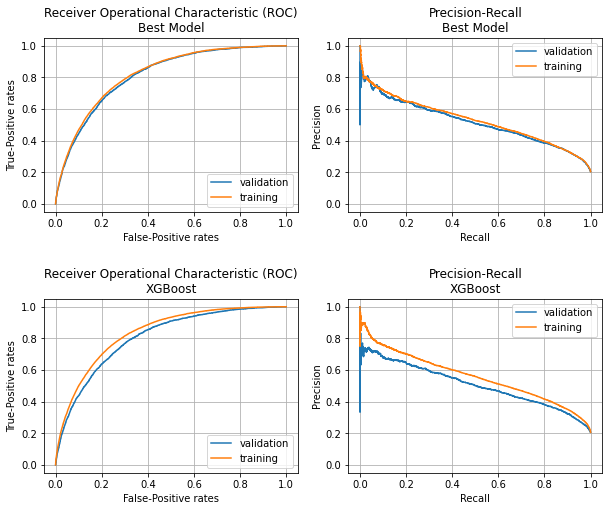

In [50]:

pred_best_train = best_model.predict(train.drop('no_show', axis=1))
prob_best_train = best_model.predict_proba(train.drop('no_show', axis=1))[:,1]
prob_xg_train = xgb_model.predict(dtrain)
pred_xg_train = [1 if prob >= 0.5 else 0 for prob in prob_xg_train]

precision_best_train, recall_best_train, _ = precision_recall_curve(train.no_show, prob_best_train)
precision_xg_train, recall_xg_train, _ = precision_recall_curve(train.no_show, prob_xg_train)
fp_rates_best_valid, tp_rates_best_valid, _ = roc_curve(valid.no_show, prob_best_valid)
fp_rates_best_train, tp_rates_best_train, _ = roc_curve(train.no_show, prob_best_train)
fp_rates_xg_valid, tp_rates_xg_valid, _ = roc_curve(valid.no_show, prob_xg_valid)
fp_rates_xg_train, tp_rates_xg_train, _ = roc_curve(train.no_show, prob_xg_train)

fig, axs = plt.subplots(2,2)
fig.set_size_inches(10,8)
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)

def plotROC(model, i, j,  fp_rates_valid, tp_rates_valid,
                          fp_rates_train, tp_rates_train):
  axs[i,j].plot(fp_rates_valid, tp_rates_valid, label='validation')
  axs[i,j].plot(fp_rates_train, tp_rates_train, label='training')
  axs[i,j].set(title = 'Receiver Operational Characteristic (ROC)'+'\n'+model,
               xlabel = 'False-Positive rates', ylabel = 'True-Positive rates',
               ylim = (-0.05,1.05), xlim = (-0.05,1.05))
  axs[i,j].legend()
  axs[i,j].grid()

def plotPR(model, i, j,  recall_valid, precision_valid,
                         recall_train, precision_train):
  axs[i,j].plot(recall_valid, precision_valid, label='validation')
  axs[i,j].plot(recall_train, precision_train, label='training')
  axs[i,j].set(title = 'Precision-Recall'+'\n'+model,
               xlabel = 'Recall', ylabel = 'Precision',
               ylim = (-0.05,1.05), xlim = (-0.05,1.05))
  axs[i,j].legend()
  axs[i,j].grid()

plotROC('Best Model', 0, 0, fp_rates_best_valid, tp_rates_best_valid , 
                               fp_rates_best_train, tp_rates_best_train )
plotPR('Best Model' , 0, 1, recall_best_valid  , precision_best_valid, 
                               recall_best_train  , precision_best_train)
plotROC('XGBoost'      , 1, 0, fp_rates_xg_valid, tp_rates_xg_valid , 
                               fp_rates_xg_train, tp_rates_xg_train )
plotPR('XGBoost'       , 1, 1, recall_xg_valid  , precision_xg_valid, 
                               recall_xg_train  , precision_xg_train)
pass

Comparing the training results with the validation, we can see that Random Forest heavily overfits while XGBoost gives much more similar results between training and validation.

In [51]:

print(tabulate([['Best Model', acc_best, ROC_AUC_best, PR_AUC_best],
                ['XGBoost', acc_xg, ROC_AUC_xg, PR_AUC_xg]],
                headers=['Accuracy', 'AUC', 'AUC-PR']))

              Accuracy       AUC    AUC-PR
----------  ----------  --------  --------
Best Model    0.815369  0.813363  0.515698
XGBoost       0.814585  0.806149  0.505724


As we can see, in all the metrics the XGBoost performs better than the random forest, obtaining higher values. Thus, we will use the XGBoost as our final model! We encourage you to explore new models and to optimize the hyperparameters they have. 

### 3.3.5 Feature Importance
It can be insightful to analyze which variables are more significant to our model, that is to say, which are the features that allow the model to predict the target variable. We will analyze this using feature importance metrics from XGBoost and Random Forest models. For example, we could measure the number of times a feature is used to split the data across all trees as a feature importance metric. Luckily, `sklearn` and `xgboost` already provides these metrics.


Despite being similar to the correlation already analyzed in the EDA section, now we are exploring which are the variables that were more relevant for the model itself, thus the results can be somewhat different.

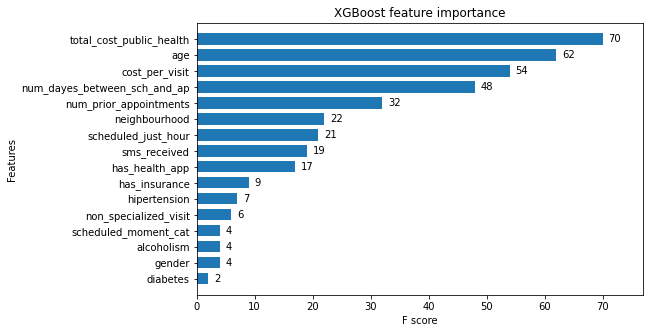

In [52]:
# Feature Importances

# weight as the importance type (number of times a feature appears in a tree)
plt.rcParams["figure.figsize"] = (8,5)
plot_importance(xgb_model, height=0.7, grid=False, title="XGBoost feature importance")
plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]

As we can see, `total_cost_public_health` is the most relevant feature for our XGBoost model, followed by `cost_per_visit` and `num_days_between_sch_and_ap`, a feature we previously engineered! For the Random Forest:

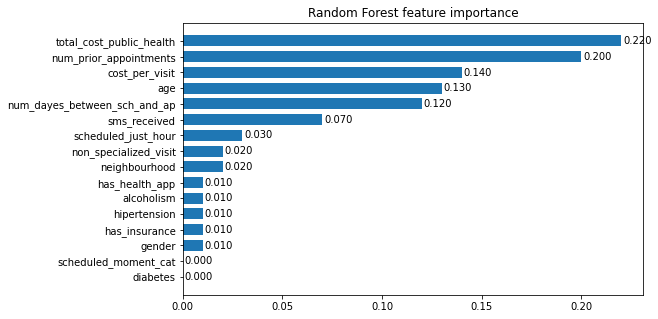

In [44]:
plt.rcParams["figure.figsize"] = (8.25,5)
sorted_index = best_model.feature_importances_.argsort()
parameters = list(train.drop('no_show', axis=1).columns)
plt.barh([parameters[i] for i in sorted_index], best_model.feature_importances_[sorted_index], height=.7)
plt.title('Random Forest feature importance')
for x, y in zip(best_model.feature_importances_[sorted_index], np.arange(len(parameters))):
  plt.text(x + .001, y, f'{x:.3f}', va='center')
plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]

As before, `num_days_between_sch_and_ap` is the most relevant feature followed by `total_cost_public_health`.

As we have seen, there are variables that really stand out for our models, as `total_cost_public_health`. Still, could we have a more insightful analysis for these features? Do more `total_cost_public_health` translates in `no_show` being more probable or viceversa? Let's explore other feature importance metrics, as SHAP.

In [45]:
explainer = shap.Explainer(xgb_model)
shap_values = explainer(train.drop('no_show', axis=1).sample(frac=0.01, random_state=123) )

#X_test
shap.summary_plot(shap_values, train.drop('no_show', axis=1).sample(frac=0.01, random_state=123))

Exception: ignored

From the chart above, we can see (among others):
- The number of days between scheduling date and appointment date is positively associated with the target. This means that the more time elapses between shceduling an appointment, the more likely is a no show.

- Those appointments for which the patient received a sms before are less likely to end as a no show.



# 3.5 Submission

The submission dataset is the dataset that will be used to measure the performance of the model.

This data is just a subset of the train dataset, whose target has been reserved. The goal is to apply the same transformations that were applied on training, and then use the model to make predictions over this new dataset.

We (the organizers) have the real 0's and 1's of each appointment in the test. Our task is to give a prediction between 0 and 1 (no need to cut the prediction into 0's and 1's) for each row. Later, we will compare your predictions with the real targets.

The metric we will use is the ROC AUC.

**Note**: it is very important that you provide not only the predictions, but also the appointment ID of each row. Otherwise, we won't be able to relate your prediction with the real targets. 

In [ ]:

def imputation(dataset, verbose=True):
  print('—'*60, 'IMPUTATION')
  if verbose:

    n_rows, n_cols = dataset.shape
    n_cells_na = dataset.isnull().sum().sum()
    n_rows_na = n_rows - dataset.dropna().shape[0]
    n_cells = n_rows * n_cols

    print(
        f"""
        Number of missing cells:     {n_cells_na} cells ({100*n_cells_na/n_cells:.2f} % of total)
        Number of rows with missing: {n_rows_na} rows ({100*n_rows_na/n_rows:.2f} % of total)
        """
    )

    print('Attribute name \t\t Missing values (%)')
    print('—'*45)
    print(dataset.isnull().sum() / dataset.shape[0] * 100)
    print()


  public_health_cost_mean = dataset['total_cost_public_health'].mean()
  age_mean = dataset['age'].mean()

  if verbose:
    print(f'public_health_cost_mean: {public_health_cost_mean}')
    print(f'age_mean: {age_mean}')

  dataset['total_cost_public_health'].fillna(public_health_cost_mean, inplace=True)
  dataset['age'].fillna(age_mean, inplace=True)
  dataset.fillna(dataset.mode().iloc[0], inplace=True)
  
  if verbose:
    print(f"Number of null cells after imputation: {dataset.isnull().sum().sum()}")

  return dataset

def feature_engineering(dataset, verbose=True):
  print('—'*60, 'FEATURE ENGINEERING')
  # Define a lambda functions that will extract substrings from the dates
  extract_date = lambda x: x[:10]
  extract_hour = lambda x: x[11:19]

  # Extract dates
  if verbose: print('Extracting dates...', end='')
  dataset['scheduled_date']   = dataset['scheduled_day'].apply(extract_date)
  dataset['appointment_date'] = dataset['appointment_day'].apply(extract_date)
  if verbose: print('OK.')

  # Extract hours
  if verbose: print('Extracting hours...', end='')
  dataset['scheduled_hour'] = dataset['scheduled_day'].apply(extract_hour)
  dataset['appointment_hour'] = dataset['appointment_day'].apply(extract_hour)
  if verbose: print('OK.')

  # to operate between dates we first need to convert them to a date format
  # to do so, we'll use datetime library
  if verbose: print('Converting to date format...', end='')
  to_date_format = lambda x: datetime.datetime.strptime(x, '%Y-%m-%d').date()
  dataset['scheduled_date_2'] = dataset['scheduled_date'].apply(to_date_format)
  dataset['appointment_date_2'] = dataset['appointment_date'].apply(to_date_format)
  if verbose: print('OK.')

  # Now we can compute the difference between dates
  if verbose: print('Computing the difference between dates...', end='')
  dataset['num_dayes_between_sch_and_ap'] = (dataset['appointment_date_2'] - 
                                              dataset['scheduled_date_2']).dt.days
  dataset[['scheduled_date_2','appointment_date_2','num_dayes_between_sch_and_ap']].head()
  if verbose: print('OK.')

  # We can drop now the appointment and schedule dates
  if verbose: print('Droping useless attributes...', end='')
  to_drop = ['scheduled_date', 'appointment_date', 'scheduled_date_2',
            'appointment_date_2','scheduled_day','appointment_day']
  dataset = dataset.drop(to_drop, axis=1)
  if verbose: print('OK.')

  # for some reason appointment hours are constant at 0am, thus they are useless
  dataset = dataset.drop('appointment_hour', axis=1)
  dataset['scheduled_just_hour'] = dataset['scheduled_hour'].apply(lambda x: pd.to_numeric(x[:2]) )

  # Now categorize the hours into morning, afternoon and night
  # Start with night and then relevel those values with either morning or afternoon
  if verbose: print('Categorizing hours into morning, afternoon and night.', end='')
  dataset['scheduled_moment_cat'] = 'night'
  dataset.loc[(dataset['scheduled_just_hour'] > 6)  &
              (dataset['scheduled_just_hour'] <= 14),
              'scheduled_moment_cat'] = 'morning'

  dataset.loc[(dataset['scheduled_just_hour'] > 14)  &
              (dataset['scheduled_just_hour'] <= 21),
              'scheduled_moment_cat'] = 'afternoon'
  if verbose: print('OK.')
              
  # Let's drop the hours columns, but we'll keep the "scheduled_just_hour", who knows
  # it might be useful after all

  if verbose: print('Droping useless attributes...', end='')
  to_drop = ['scheduled_hour']#, 'appointment_hour']
  dataset = dataset.drop(to_drop, axis=1)
  if verbose: print('OK')

  if verbose: print('Calculating cost per visit...', end='')
  dataset['cost_per_visit'] = dataset['total_cost_public_health']/dataset['num_prior_appointments']
  # Fill infinite values with 0's
  dataset = dataset.replace([np.inf, -np.inf], 0)
  dataset.fillna(0, inplace=True)
  if verbose: print('OK')
  
  return dataset

def standarization(dataset,scaler=None ,verbose=True):
  print('—'*60, 'STANDARIZATION')

  # Split data intro numerical features and categorical features

  if verbose: print('Starting standarization...', end='')

  num_features = ['num_dayes_between_sch_and_ap','cost_per_visit', 'total_cost_public_health',
                'scheduled_just_hour','age']
  df_num = dataset[num_features]
  df_num_scaled = scaler.transform(df_num)

  # Convert it back to a pandas Data Frame
  df_num_scaled = pd.DataFrame(df_num_scaled, columns=df_num.columns)

  # Concatenate numeric with categorical into a whole dataset again
  # extract cat columns
  cat_features = [col for col in dataset.columns if col not in num_features]
  df_cat = dataset[cat_features]

  # Concatenate categorical and numerical back together
  dataset = pd.concat([df_cat, df_num_scaled], axis=1)

  if verbose: print('OK.')

  return dataset

def encoding(dataset, vars_to_encode):
  print('—'*60, 'ENCODING')
  # We can use the function pd.get_dummies to generate binary variables automatically

  df_to_encode= dataset[vars_to_encode]
  df_encoded = pd.get_dummies(df_to_encode, drop_first = True)

  # Drop non encodded variabes from dataset
  dataset = dataset.drop(vars_to_encode, axis=1)

  # Add the encoded dataset to the train dataset
  dataset = pd.concat([dataset, df_encoded], axis=1)

  return dataset

def preprocess(dataset,scaler, verbose=True):
  print(dataset.shape[0])
  dataset = imputation(dataset, verbose)
  print(dataset.shape[0])
  dataset = feature_engineering(dataset, verbose)
  print(dataset.shape[0])
  dataset = standarization(dataset, scaler=scaler, verbose=verbose)
  print(dataset.shape[0])
  dataset = encoding(dataset, vars_to_encode=['gender','neighbourhood','scheduled_moment_cat'])
  return dataset

In [ ]:
df_test = pd.read_csv('test.csv')

# Separate the appointment_id in test, as we won't pass it to the model,
# But we still need it to relate the predictions with the targets.
app_ids_test = df_test['appointment_id']
df_test = df_test.drop('appointment_id', axis=1)
df_test = preprocess(df_test, verbose=True, scaler=ss)

In [ ]:
# Last touches so the test data can be passed to the model
cols_train = df_train.columns.tolist()
cols_train.remove('no_show')
df_test = df_test[cols_train] 
def sorted_columns(dataset):
  return list(sorted(list(dataset.columns)))

print('Check whether they have the same columns:')
sorted_columns(df_train.drop('no_show', axis=1)) == sorted_columns(df_test)

In [ ]:
prob_xg_test = xgb_model.predict(xgb.DMatrix(df_test))
prob_xg_test =pd.Series(prob_xg_test)
# Since the 
#pred_xg_test = [1 if prob >= 0.5 else 0 for prob in prob_xg_test]

# Add the appointment id, so the predictions can be compared with the target
prob_series = pd.Series(prob_xg_test)
df_submission = pd.concat([app_ids_test,prob_xg_test], axis=1)
df_submission.columns = ['appointment_id','prediction']
df_submission.to_csv('submission.csv')


In [ ]:
# Only if you have the targets for the test data, which you won't
have_test_targets = False
if have_test_targets:
  # Evaluate submission agains test targets
  df_test_targets = pd.read_csv('test_with_target.csv')[['appointment_id','no_show']]
  df_test_targets.head()

  # Merge with the submissio and compare the AUC on test
  df_sub_targets = pd.merge(df_submission, df_test_targets, on='appointment_id')
  auc_test = roc_auc_score(df_sub_targets['no_show'], df_sub_targets['prediction'])
  print(f'AUC over test = {auc_test}')

# 3.6 Further ideas


Here is a list of ideas you can use to improve the model


*   **New features**: can you come up with other engineered features?
*   **Other algorithms**: linear models, Support Vector Machines, Random Forest, etc
*   **Tune the hyperparameters of the model**: Hyperparameters are parameters whose values control the learning process and determine the values of model parameters that a learning algorithm ends up learning. Hyperparameter tuning is the problem of choosing a set of optimal hyperparameters for a learning algorithm.

*   Do your own research: The possibilities are unlimited





# References
[1] Marbouh, D., Khaleel, I., Al Shanqiti, K., Al Tamimi, M., Simsekler, M., Ellahham, S., Alibazoglu, D., & Alibazoglu, H. (2020). *Evaluating the Impact of Patient No-Shows on Service Quality*. Risk management and healthcare policy, 13, 509–517. https://doi.org/10.2147/RMHP.S232114